# Dealing with Outliers
1. Model data as some analytic distribution
2. Find all points below a certain probability
3. Remove them
4. Refit distributions, and potentially run steps again

In [293]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.stats import multivariate_normal as mn

In [268]:
df = pd.read_csv('clean_marketing_data.csv')

In [269]:
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Response,Complain,Country
0,1826,1970,Graduation,Divorced,"$84,835.00",0,0,6/16/14,0,189,...,6,1,0,0,0,0,0,1,0,SP
1,1,1961,Graduation,Single,"$57,091.00",0,0,6/15/14,0,464,...,7,5,0,0,0,0,1,1,0,CA
2,10476,1958,Graduation,Married,"$67,267.00",0,1,5/13/14,0,134,...,5,2,0,0,0,0,0,0,0,US
3,5371,1989,Graduation,Single,"$21,474.00",1,0,4/8/14,0,6,...,2,7,1,0,0,0,0,1,0,SP
4,7348,1958,PhD,Single,"$71,691.00",0,0,3/17/14,0,336,...,5,2,0,0,0,0,0,1,0,SP


In [270]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1832 entries, 0 to 1831
Data columns (total 28 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ID                   1832 non-null   int64 
 1   Year_Birth           1832 non-null   int64 
 2   Education            1832 non-null   object
 3   Marital_Status       1832 non-null   object
 4    Income              1832 non-null   object
 5   Kidhome              1832 non-null   int64 
 6   Teenhome             1832 non-null   int64 
 7   Dt_Customer          1832 non-null   object
 8   Recency              1832 non-null   int64 
 9   MntWines             1832 non-null   int64 
 10  MntFruits            1832 non-null   int64 
 11  MntMeatProducts      1832 non-null   int64 
 12  MntFishProducts      1832 non-null   int64 
 13  MntSweetProducts     1832 non-null   int64 
 14  MntGoldProds         1832 non-null   int64 
 15  NumDealsPurchases    1832 non-null   int64 
 16  NumWeb

# 1. 1D Data

## Use the `Income` column
#### Needs some cleanup

In [271]:
df.rename({" Income ": "Income"}, axis=1, inplace=True)

In [272]:
df['Income'] = df['Income'].apply(lambda x: x[1:])

In [273]:
df['Income'] = df['Income'].apply(lambda x: x.replace(' ', ''))
df['Income'] = df['Income'].apply(lambda x: x.replace(',', '')) 

In [274]:
df = df[df["Income"] != "one"]

In [275]:
df['Income'] = df['Income'].astype(float)

In [276]:
df.columns

Index(['ID', 'Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome',
       'Teenhome', 'Dt_Customer', 'Recency', 'MntWines', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Response', 'Complain', 'Country'],
      dtype='object')

In [277]:
df_1d = df["Income"]

In [278]:
df_1d.head()

0    84835.0
1    57091.0
2    67267.0
3    21474.0
4    71691.0
Name: Income, dtype: float64

## Now Use the Basic Steps
#### For 1D data, Z-Score is a good way to filter

In [279]:
# Get mean and stdev
mean, std = np.mean(df_1d), np.std(df_1d)

In [284]:
# Get z_Score (How many st.devs away from the mean)
z_score = np.abs((df_1d - mean) / std)

In [281]:
# Set a threshold
threshold = 3

In [282]:
# Define what to keep
good_data = z_score < threshold

Rejection 7 points
z-score of 3 corresponds to a prob of 0.26997960632601864%


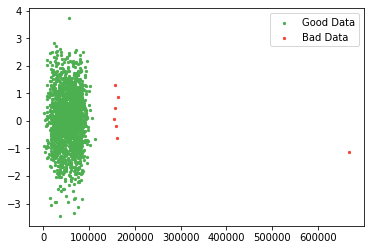

In [283]:
# Plot it
print('Rejection {} points'.format((~good_data).sum()))
print('z-score of {} corresponds to a prob of {}%'.format(threshold, 100 * 2 * norm.sf(threshold)))
visual_scatter = np.random.normal(size=df_1d.size)
plt.scatter(df_1d[good_data], visual_scatter[good_data], s=5, label='Good Data', color="#4CAF50")
plt.scatter(df_1d[~good_data], visual_scatter[~good_data], s=5, label='Bad Data', color="#F44336")
plt.legend()

# 2. 2D Data

## Use the `Income` and `MntWines` columns

In [317]:
df_2d = df[['Income', 'MntWines']]

## Now Use the Basic Steps
#### For 2D data, `multivariate_normal` is a good filter

In [326]:
# Get mean and covariance as 2D Gaussian
mean, cov = np.mean(df_2d, axis=0), np.cov(df_2d.T)

In [372]:
# Define good data using probability being bigger than some number
good_data_2d = mn(mean, cov).pdf(df_2d) > 0.00000001 / 100

In [373]:
df_2d_good = df_2d[good_data_2d]

In [374]:
df_2d_bad = df_2d[~good_data_2d]

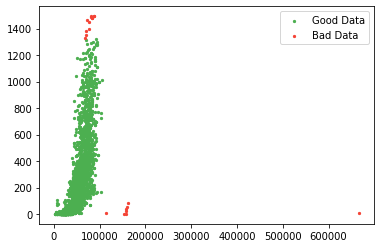

In [375]:
# Plot
plt.scatter(df_2d_good['Income'], df_2d_good['MntWines'], s=5, label='Good Data', color='#4CAF50')
plt.scatter(df_2d_bad['Income'], df_2d_bad['MntWines'], s=5, label='Bad Data', color='#F44336')
plt.legend()
plt.show()

# 3. Rejection Sampling

#### Rewatch / follow lecture if ever needed!!!

# That was all manual though....

#### Use `sklearn.neighbors` package `LocalOutlierFactor` to do this automatically